# Image Segmentation

In [5]:
# Essential packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image

# ML packages
#!pip install torch torchvision torchmetrics pytorch-lightning optuna optuna-integration[pytorch_lightning]
import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset

import optuna
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, classification_report, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
)

torch.set_float32_matmul_precision('medium')

# Load data
Xtrain2_a = np.load("./data/Xtrain2_a.npy")
Ytrain2_a = np.load("./data/Ytrain2_a.npy")
Xtrain2_b = np.load("./data/Xtrain2_b.npy")
Ytrain2_b = np.load("./data/Ytrain2_b.npy")
Xtest2_a = np.load("./data/Xtest2_a.npy")
Xtest2_b = np.load("./data/Xtest2_b.npy")

print(f"Xtrain2_a shape: {Xtrain2_a.shape}")
print(f"Ytrain2_a shape: {Ytrain2_a.shape}")
print(f"Xtrain2_b shape: {Xtrain2_b.shape}")
print(f"Ytrain2_b shape: {Ytrain2_b.shape}")
print(f"Xtest2_a shape: {Xtest2_a.shape}")
print(f"Xtest2_b shape: {Xtest2_b.shape}")

Xtrain2_b shape: (547, 2304)
Ytrain2_b shape: (547, 2304)


## Data Exploration

Number of patches: 964908, Image size: 49
Number of classes: 2



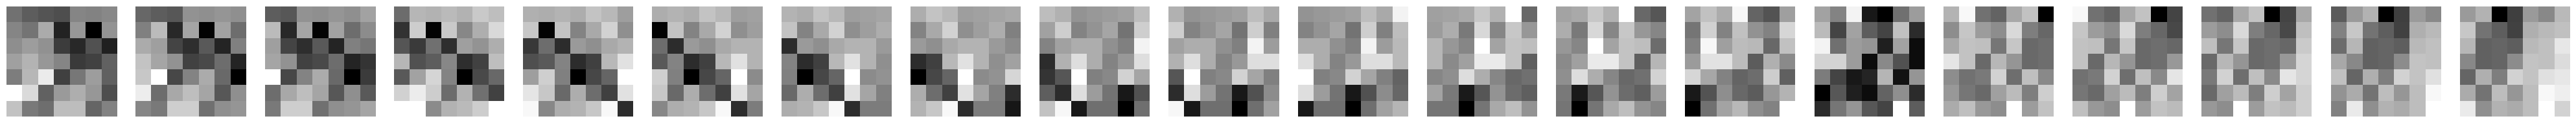

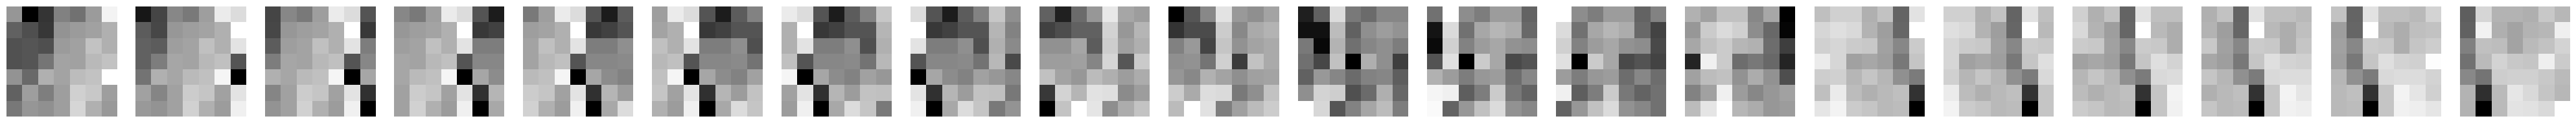

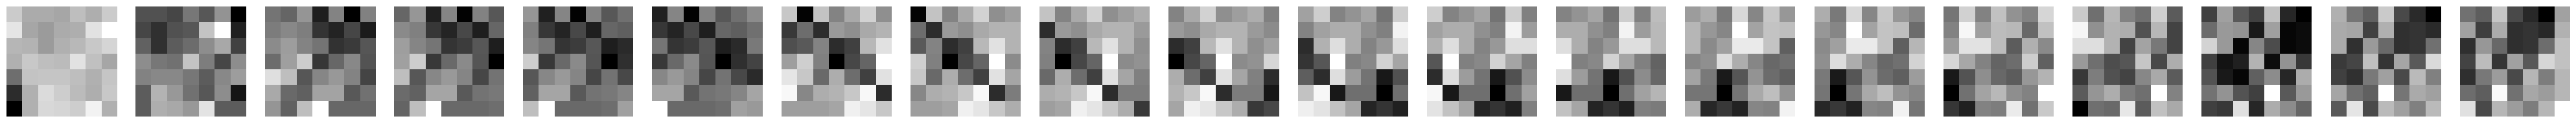

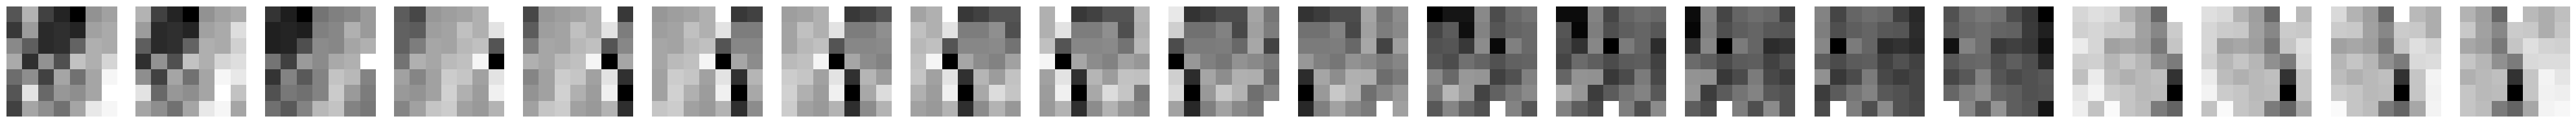

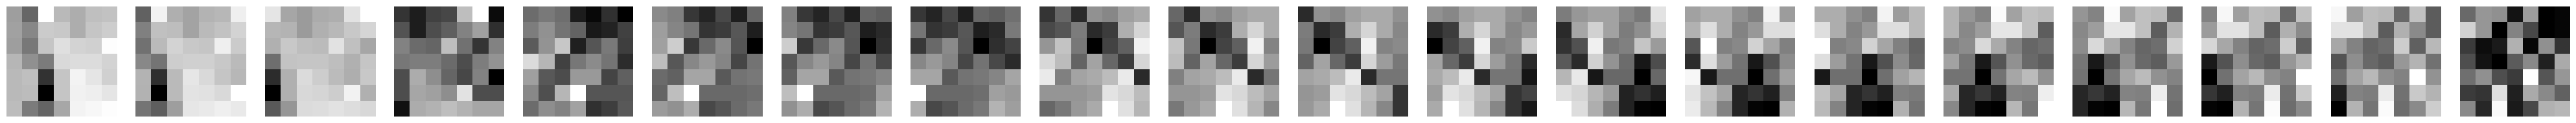

In [ ]:
print(f"Number of patches: {Xtrain2_a.shape[0]}, Image size: {Xtrain2_a.shape[1]}")
print(f"Number of classes: {len(np.unique(Ytrain2_a))}\n")

# Print all images
#num_images = Xtrain2_a.shape[0]
num_images = 100
img_shape = (7, 7)

images_per_figure = 20
cols = 20
rows = int(np.ceil(images_per_figure / cols))

# Loop through all images in batches
for start_idx in range(0, num_images, images_per_figure):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        img_idx = start_idx + i
        if img_idx < num_images:
            img = Xtrain2_a[img_idx, :].reshape(img_shape)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

Number of patches: 547, Image size: 2304
Number of classes: 2



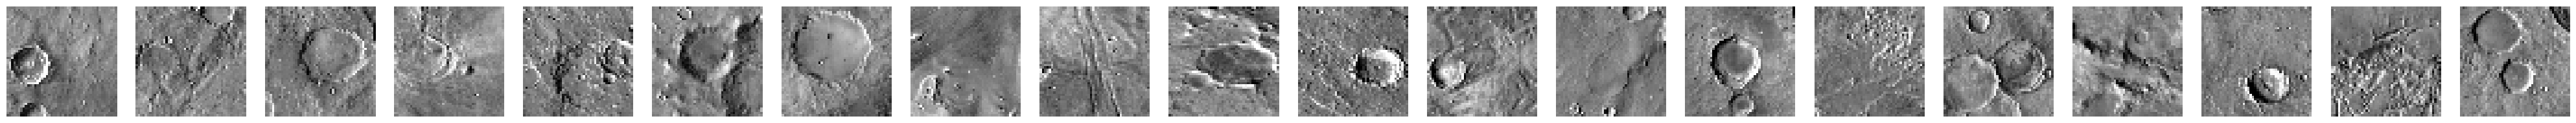

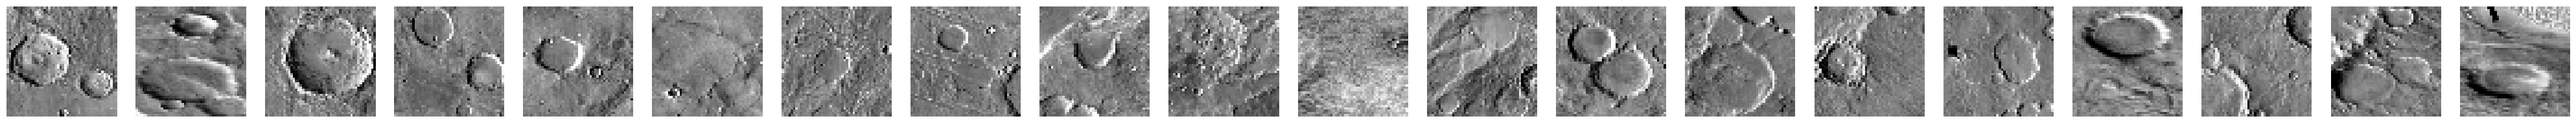

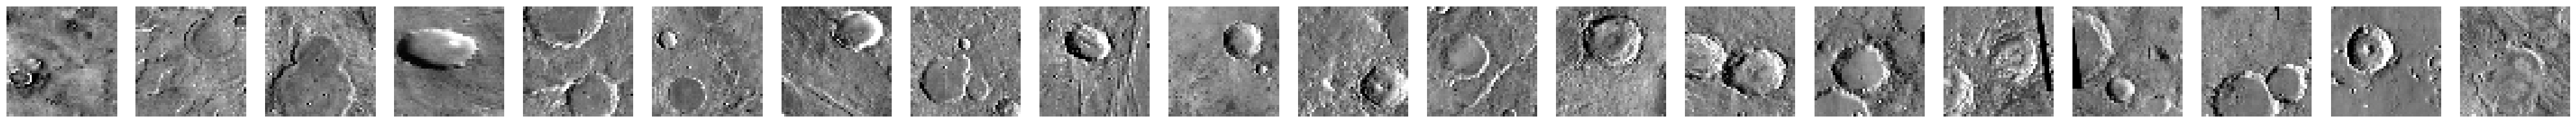

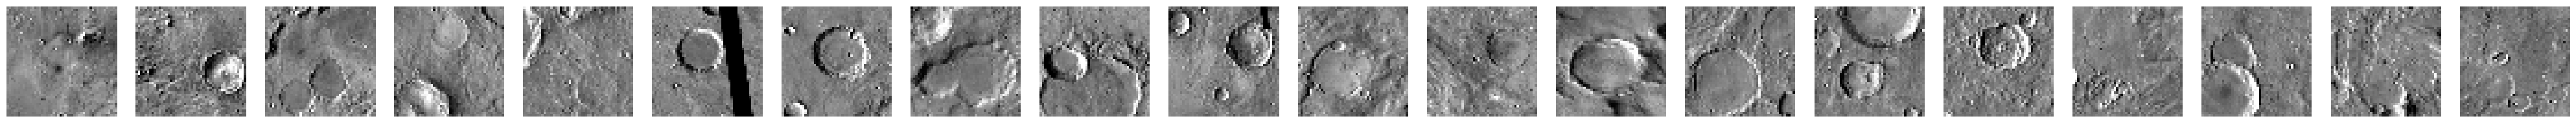

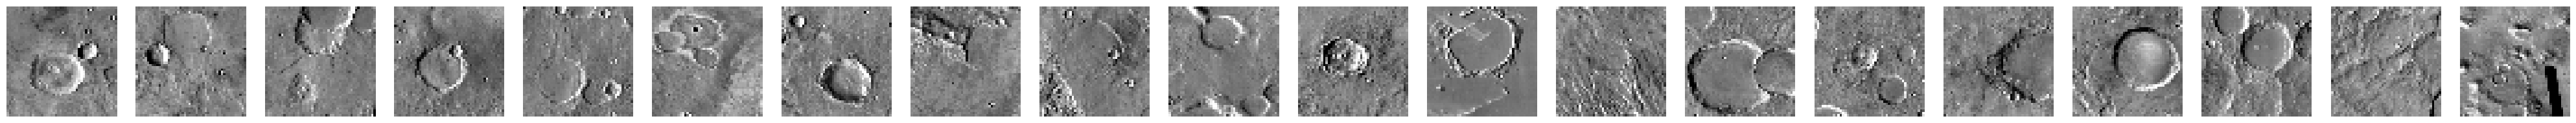

In [ ]:
print(f"Number of patches: {Xtrain2_b.shape[0]}, Image size: {Xtrain2_b.shape[1]}")
print(f"Number of classes: {len(np.unique(Ytrain2_b))}\n")

# Print all images
#num_images = Xtrain2_b.shape[0]
num_images = 100
img_shape = (48, 48)

images_per_figure = 20
cols = 20
rows = int(np.ceil(images_per_figure / cols))

# Loop through all images in batches
for start_idx in range(0, num_images, images_per_figure):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        img_idx = start_idx + i
        if img_idx < num_images:
            img = Xtrain2_b[img_idx, :].reshape(img_shape)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

## Model Training (Format A)

### Data Preparation

In [ ]:
class CratersPatchDataset(Dataset):
  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]

    # Convert the image (numpy array) to PIL image
    image_pil = Image.fromarray(image.squeeze(), mode='L')  # mode 'L' for grayscale

    # Apply transform if available
    if self.transform:
        image = self.transform(image_pil)
    else:
        image = transforms.ToTensor()(image_pil)

    # Return image and label
    return image, torch.tensor(label, dtype=torch.float32)

# Data transformations
train_transform = transforms.Compose([
  transforms.ToTensor(),
  #transforms.Normalize(mean=[0.5], std=[0.5])
])

# Validation transform
val_transform = transforms.Compose([
  transforms.ToTensor(),
])

# Reshaping tensors
patches = Xtrain2_a.reshape(-1, 1, 7, 7)
labels = Ytrain2_a

# Split into train and test
train_patches, test_patches, train_labels, test_labels = train_test_split(
  patches, labels, test_size=0.2, stratify=labels
)

# Create datasets
train_dataset_a = CratersPatchDataset(train_patches, train_labels, transform=train_transform)
val_dataset_a = CratersPatchDataset(test_patches, test_labels, transform=val_transform)

# Create DataLoader
batch_size = 32 # pode ser razoavel uma vez q temos quase 1M de dados
train_loader_a = DataLoader(train_dataset_a, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader_a = DataLoader(val_dataset_a, batch_size=batch_size, shuffle=False, num_workers=8)

# Calculate class weights to handle imbalance in the training data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
print(f"Class weights: {class_weights_tensor.numpy()}")

Class weights: [0.7426664 1.5302207]


### LR Method

#### Model Definition

In [ ]:
class SimpleLR(nn.Module):
  def __init__(self):
    super(SimpleLR, self).__init__()
    self.fc = nn.Linear(7 * 7, 1)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    return self.fc(x)

#### Training

In [ ]:
class SegmentationTask(pl.LightningModule):
  def __init__(self, model=None, criterion=None, threshold=0.5, optimizer_type='Adam', lr=1e-5, scheduler_type=None):
    super(SegmentationTask, self).__init__()

    self.model = model
    self.criterion = criterion
    self.lr = lr
    self.optimizer_type = optimizer_type
    self.scheduler_type = scheduler_type
    self.threshold = threshold

    # Define metrics for train, validation, and test
    self.metrics = {
      'train': {
        'f1': torchmetrics.F1Score(task="multiclass", num_classes=2, threshold=self.threshold, average="macro"),
        'bacc': torchmetrics.Accuracy(task="multiclass", num_classes=2, threshold=self.threshold, average="macro"),
        'losses': []
      },
      'val': {
        'f1': torchmetrics.F1Score(task="multiclass", num_classes=2, threshold=self.threshold, average="macro"),
        'bacc': torchmetrics.Accuracy(task="multiclass", num_classes=2, threshold=self.threshold, average="macro"),
        'losses': []
      },
      'test': {
        'f1': torchmetrics.F1Score(task="multiclass", num_classes=2, threshold=self.threshold, average="macro"),
        'bacc': torchmetrics.Accuracy(task="multiclass", num_classes=2, threshold=self.threshold, average="macro"),
        'losses': []
      }
    }

  def forward(self, x):
    return self.model(x)

  def _step(self, batch, phase):
    x, y = batch
    logits = self(x).view(-1).to(self.device)

    # Ensure metrics are on the correct device
    self.metrics[phase]['bacc'].to(self.device)
    self.metrics[phase]['f1'].to(self.device)

    # Predictions and loss calculation
    preds = torch.sigmoid(logits) >= self.threshold
    loss = self.criterion(logits.flatten(), y.flatten())

    # Update the metrics
    self.metrics[phase]['losses'].append(loss.item())
    self.metrics[phase]['bacc'](preds.flatten(), y.flatten())
    self.metrics[phase]['f1'](preds.flatten(), y.flatten())

    return loss

  def training_step(self, batch, batch_idx):
    return self._step(batch, 'train')

  def validation_step(self, batch, batch_idx):
    return self._step(batch, 'val')

  def test_step(self, batch, batch_idx):
    return self._step(batch, 'test')

  def _epoch_end(self, phase):
    avg_loss = torch.tensor(self.metrics[phase]['losses']).mean()
    avg_bacc = self.metrics[phase]['bacc'].compute()
    avg_f1 = self.metrics[phase]['f1'].compute()

    # Log the metrics
    self.log(f'{phase}_loss_epoch', avg_loss, prog_bar=True)
    self.log(f'{phase}_bacc_epoch', avg_bacc, prog_bar=True)
    self.log(f'{phase}_f1_epoch', avg_f1, prog_bar=True)

    # Reset metrics for the next epoch
    self.metrics[phase]['losses'].clear()
    self.metrics[phase]['bacc'].reset()
    self.metrics[phase]['f1'].reset()

  def on_train_epoch_end(self):
    self._epoch_end('train')

  def on_validation_epoch_end(self):
    self._epoch_end('val')

  def on_test_epoch_end(self):
    self._epoch_end('test')

  def configure_optimizers(self):
    if self.optimizer_type == 'Adam':
      optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-5)
    else:
      raise ValueError(f"Unsupported optimizer type: {self.optimizer_type}")

    if self.scheduler_type == 'ReduceLROnPlateau':
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3)
      return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_loss_epoch'}}
    elif self.scheduler_type == 'StepLR':
      scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
      return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': scheduler}}
    else:
      return optimizer

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# This redefinition is just a bug fix...
class OptunaPruning(PyTorchLightningPruningCallback, pl.Callback):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

# Define Optuna's objective function, optimized for F1-score
def Objective(train_loader, val_loader, class_weights_tensor, trial):
  # Suggest hyperparameters to tune
  lr = trial.suggest_float('lr', 1e-4, 1e-3, log=True)
  threshold_opt = trial.suggest_float('threshold', 0.3, 0.9)
  optimizer_type = trial.suggest_categorical('optimizer_type', ['Adam'])

  # Modify the model with the trial's suggested dropout rate
  model = SimpleLR()

  # Define the loss function with class weights
  criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])

  # Create a classification task instance using suggested hyperparameters
  segmentation_task = SegmentationTask(
    model=model,
    criterion=criterion,
    threshold=threshold_opt,
    optimizer_type=optimizer_type,
    lr=lr,
    scheduler_type='ReduceLROnPlateau'
  )

  # Early stopping callback based on F1 score
  early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_loss_epoch',
    patience=10,
    verbose=True,
    mode='min',
    min_delta=0.001
  )

  # Model checkpoint to save the best model's weights
  checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f"lightning_logs/optuna_trials/trial_{trial.number}",
    filename=f"best_model_trial_{trial.number}",
    monitor='val_bacc_epoch',
    save_top_k=1,
    mode='max'
  )

  # Set up the logger to store logs in the optuna_trials directory
  logger = pl.loggers.TensorBoardLogger("lightning_logs/optuna_trials", name=f"trial_{trial.number}")

  # Set up the PyTorch Lightning Trainer with pruning callback
  trainer = pl.Trainer(
    max_epochs=30,
    logger=logger,
    accelerator="auto",
    strategy="auto",
    devices="auto",
    callbacks=[
        early_stopping,
        checkpoint_callback,
        OptunaPruning(trial, monitor="val_bacc_epoch")
    ],
    accumulate_grad_batches=4,
    #log_every_n_steps=0,        # No logging during steps
    #enable_progress_bar=False,  # Disable the progress bar
    #enable_model_summary=False  # Disable the model summary output
  )

  # Train the model
  trainer.fit(segmentation_task, train_loader, val_loader)

  # Load the best model checkpoint for final evaluation
  best_model_path = checkpoint_callback.best_model_path
  best_task = SegmentationTask.load_from_checkpoint(
    checkpoint_path=best_model_path,
    model=model,
    criterion=criterion,
  )
  best_task.eval()

  # Set up the balanced accuracy metric
  bacc_metric = torchmetrics.Accuracy(
    task="multiclass", num_classes=2, threshold=threshold_opt, average="macro"
  ).to(best_task.device)

  # Perform evaluation on validation set
  with torch.no_grad():
    for batch in val_loader:
      batch = [item.to(best_task.device) for item in batch]
      x, y = batch
      logits = best_task.model(x)
      preds = torch.sigmoid(logits) >= threshold_opt
      bacc_metric.update(preds.flatten(), y.flatten())

  # Compute and return the final balanced accuracy score for this trial
  bacc_score = bacc_metric.compute().item()
  bacc_metric.reset()

  # Print the BAcc score for the current trial
  print(f"\nTrial {trial.number}: BAcc Score = {bacc_score:.6f}\n")

  return bacc_score

In [ ]:
# Set up the Optuna study and optimize the objective
study = optuna.create_study(direction="maximize")
study.optimize(
  lambda trial: Objective(train_loader_a, val_loader_a, class_weights_tensor, trial),
  n_trials=1 # Perform N trials of hyperparameter search
)

# Print the best hyperparameters found by Optuna
best_trial = study.best_trial
print(f"Best trial (number {best_trial.number}):")
print(f"  BAcc: {best_trial.value}")
print(f"  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/lightning_logs/optuna_trials/trial_0 exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | SimpleLR          | 50     | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
50        Trainable params
0         N

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss_epoch improved. New best score: 0.803


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss_epoch did not improve in the last 10 records. Best score: 0.803. Signaling Trainer to stop.



Trial 0: BAcc Score = 0.500008

Best trial (number 0):
  BAcc: 0.5000079274177551
  Params: 
    lr: 0.00038454665420022507
    threshold: 0.5995348683531299
    optimizer_type: Adam


In [ ]:
# Print the best hyperparameters found by Optuna
best_trial = study.best_trial
print(f"Best trial (number {best_trial.number}):")
print(f"  BAcc: {best_trial.value}")
print(f"  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

#### LR Performance Visualization

### MLP Method

#### Model Definition

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()

        self.fc1 = nn.Linear(7 * 7, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)

        self.activation = nn.ReLU() # em principio o leaky relu não é necessário
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.activation(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        return self.fc3(x)

#### Training

In [ ]:
class SegmentationTask(pl.LightningModule):
  def __init__(self, model=None, criterion=None, threshold=0.5, optimizer_type='Adam', lr=1e-5, scheduler_type=None):
    super(SegmentationTask, self).__init__()

    self.model = model
    self.criterion = criterion
    self.lr = lr
    self.optimizer_type = optimizer_type
    self.scheduler_type = scheduler_type
    self.threshold = threshold

    # Define metrics for train, validation, and test
    self.metrics = {
      'train': {
        'f1': torchmetrics.F1Score(task="multiclass", num_classes=2, threshold=self.threshold, average="macro"),
        'bacc': torchmetrics.Accuracy(task="multiclass", num_classes=2, threshold=self.threshold, average="macro"),
        'losses': []
      },
      'val': {
        'f1': torchmetrics.F1Score(task="multiclass", num_classes=2, threshold=self.threshold, average="macro"),
        'bacc': torchmetrics.Accuracy(task="multiclass", num_classes=2, threshold=self.threshold, average="macro"),
        'losses': []
      },
      'test': {
        'f1': torchmetrics.F1Score(task="multiclass", num_classes=2, threshold=self.threshold, average="macro"),
        'bacc': torchmetrics.Accuracy(task="multiclass", num_classes=2, threshold=self.threshold, average="macro"),
        'losses': []
      }
    }

  def forward(self, x):
    return self.model(x)

  def _step(self, batch, phase):
    x, y = batch
    logits = self(x).view(-1).to(self.device)

    # Ensure metrics are on the correct device
    self.metrics[phase]['bacc'].to(self.device)
    self.metrics[phase]['f1'].to(self.device)

    # Predictions and loss calculation
    preds = torch.sigmoid(logits) >= self.threshold
    loss = self.criterion(logits, y)

    # Update the metrics
    self.metrics[phase]['losses'].append(loss.item())
    self.metrics[phase]['bacc'](preds, y)
    self.metrics[phase]['f1'](preds, y)

    return loss

  def training_step(self, batch, batch_idx):
    return self._step(batch, 'train')

  def validation_step(self, batch, batch_idx):
    return self._step(batch, 'val')

  def test_step(self, batch, batch_idx):
    return self._step(batch, 'test')

  def _epoch_end(self, phase):
    avg_loss = torch.tensor(self.metrics[phase]['losses']).mean()
    avg_bacc = self.metrics[phase]['bacc'].compute()
    avg_f1 = self.metrics[phase]['f1'].compute()

    # Log the metrics
    self.log(f'{phase}_loss_epoch', avg_loss, prog_bar=True)
    self.log(f'{phase}_bacc_epoch', avg_bacc, prog_bar=True)
    self.log(f'{phase}_f1_epoch', avg_f1, prog_bar=True)

    # Reset metrics for the next epoch
    self.metrics[phase]['losses'].clear()
    self.metrics[phase]['bacc'].reset()
    self.metrics[phase]['f1'].reset()

  def on_train_epoch_end(self):
    self._epoch_end('train')

  def on_validation_epoch_end(self):
    self._epoch_end('val')

  def on_test_epoch_end(self):
    self._epoch_end('test')

  def configure_optimizers(self):
    if self.optimizer_type == 'Adam':
      optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-6)
    else:
      raise ValueError(f"Unsupported optimizer type: {self.optimizer_type}")

    if self.scheduler_type == 'ReduceLROnPlateau':
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=3)
      return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_f1_epoch'}}
    elif self.scheduler_type == 'StepLR':
      scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
      return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': scheduler}}
    else:
      return optimizer

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# This redefinition is just a bug fix...
class OptunaPruning(PyTorchLightningPruningCallback, pl.Callback):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

# Define Optuna's objective function, optimized for F1-score
def Objective(train_loader, val_loader, class_weights_tensor, trial):
  # Suggest hyperparameters to tune
  lr = trial.suggest_float('lr', 1e-4, 1e-3, log=True)
  dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.5)
  threshold_opt = trial.suggest_float('threshold', 0.35, 0.65)
  optimizer_type = trial.suggest_categorical('optimizer_type', ['Adam'])

  # Modify the model with the trial's suggested dropout rate
  model = SimpleMLP()
  model.dropout = nn.Dropout(dropout_rate)

  # Define the loss function with class weights
  criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])

  # Create a classification task instance using suggested hyperparameters
  segmentation_task = SegmentationTask(
    model=model,
    criterion=criterion,
    threshold=threshold_opt,
    optimizer_type=optimizer_type,
    lr=lr,
    scheduler_type='ReduceLROnPlateau'
  )

  # Early stopping callback based on F1 score
  early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_loss_epoch',
    patience=5,
    verbose=True,
    mode='min',
    min_delta=0.001
  )

  # Model checkpoint to save the best model's weights
  checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f"lightning_logs/optuna_trials/trial_{trial.number}",
    filename=f"best_model_trial_{trial.number}",
    monitor='val_bacc_epoch',
    save_top_k=1,
    mode='max'
  )

  # Set up the logger to store logs in the optuna_trials directory
  logger = pl.loggers.TensorBoardLogger("lightning_logs/optuna_trials", name=f"trial_{trial.number}")

  # Set up the PyTorch Lightning Trainer with pruning callback
  trainer = pl.Trainer(
    max_epochs=30,
    logger=logger,
    accelerator="auto",
    strategy="auto",
    devices="auto",
    callbacks=[
        early_stopping,
        checkpoint_callback,
        OptunaPruning(trial, monitor="val_bacc_epoch")
    ],
    accumulate_grad_batches=4,
    #log_every_n_steps=0,        # No logging during steps
    #enable_progress_bar=False,  # Disable the progress bar
    #enable_model_summary=False  # Disable the model summary output
  )

  # Train the model
  trainer.fit(segmentation_task, train_loader, val_loader)

  # Load the best model checkpoint for final evaluation
  best_model_path = checkpoint_callback.best_model_path
  best_task = SegmentationTask.load_from_checkpoint(
    checkpoint_path=best_model_path,
    model=model,
    criterion=criterion,
  )
  best_task.eval()

  # Set up the balanced accuracy metric
  bacc_metric = torchmetrics.Accuracy(
    task="multiclass", num_classes=2, threshold=threshold_opt, average="macro"
  ).to(best_task.device)

  # Perform evaluation on validation set
  with torch.no_grad():
    for batch in val_loader:
      batch = [item.to(best_task.device) for item in batch]
      x, y = batch
      logits = best_task.model(x)
      preds = torch.sigmoid(logits) >= threshold_opt
      bacc_metric.update(preds, y)

  # Compute and return the final balanced accuracy score for this trial
  bacc_score = bacc_metric.compute().item()
  bacc_metric.reset()

  # Print the BAcc score for the current trial
  print(f"\nTrial {trial.number}: BAcc Score = {bacc_score:.6f}\n")

  return bacc_score

In [ ]:
# Set up the Optuna study and optimize the objective
study = optuna.create_study(direction="maximize")
study.optimize(
  lambda trial: Objective(train_loader_a, val_loader_a, class_weights_tensor, trial),
  n_trials=5 # Perform N trials of hyperparameter search
)

# Print the best hyperparameters found by Optuna
best_trial = study.best_trial
print(f"Best trial (number {best_trial.number}):")
print(f"  BAcc: {best_trial.value}")
print(f"  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

In [ ]:
# Print the best hyperparameters found by Optuna
best_trial = study.best_trial
print(f"Best trial (number {best_trial.number}):")
print(f"  BAcc: {best_trial.value}")
print(f"  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

#### MLP Performance Visualization

### MLP Fusion

#### Data

In [ ]:
Xtrain2_a = Xtrain2_a / 255
Xtrain2_b = Xtrain2_b / 255.0

# Single channel reshaping
Xtrain2_a = Xtrain2_a.reshape(-1, 1, 7, 7)
Xtrain2_b = Xtrain2_b.reshape(-1, 1, 48, 48)

# Convert to tensors
Xtrain2_a = torch.tensor(Xtrain2_a, dtype=torch.float32)
Ytrain2_a = torch.tensor(Ytrain2_a, dtype=torch.long)
Xtrain2_b = torch.tensor(Xtrain2_b, dtype=torch.float32)
Ytrain2_b = torch.tensor(Ytrain2_b, dtype=torch.long)

# Calculate number of images based on 1764 patches per image
num_images = Xtrain2_a.shape[0] // 1764

# Group patches by image
X_images = Xtrain2_a.view(num_images, 1764, 49)  # Flatten each patch to 49 pixels
Y_images = Ytrain2_a.view(num_images, 1764)

# Confirm shapes
print("X_images shape:", X_images.shape)  # Expected: (num_images, 1764, 49)
print("Y_images shape:", Y_images.shape)  # Expected: (num_images, 1764)

# Split into test, training, and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_images, Y_images, test_size=0.25, random_state=42)  # 60/20/20 split
X_train_global, X_val_global, Y_train_global, Y_val_global = train_test_split(Xtrain2_b, Ytrain2_b, test_size=0.25, random_state=42)


# Prepare TensorDatasets for grouped images (with 1764 patches per image)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), Y_train)
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), Y_val)

# Check shapes in TensorDatasets
print("Train dataset shapes:", X_train.shape, Y_train.shape)  # Expected: (training_patches, 49) and (training_patches,)
print("Validation dataset shapes:", X_val.shape, Y_val.shape)  # Expected: (validation_patches, 49) and (validation_patches,)

# Training dataset
train_dataset = TensorDataset(X_train, X_train_global, Y_train)
val_dataset = TensorDataset(X_val, X_val_global, Y_val)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

#### Model

In [ ]:
class FusedMLPMixer(pl.LightningModule):
    def __init__(self, patch_size=49, hidden_dim=128, token_dim=64, channel_dim=256, global_dim=512, num_classes=2, lr=0.001):
        super(FusedMLPMixer, self).__init__()
        self.lr = lr

        # Branch 1: Local Patch Processing (7x7 patches)
        self.patch_embedding = nn.Linear(patch_size, hidden_dim)
        self.token_mixing = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, token_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(token_dim, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )
        self.channel_mixing = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, channel_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(channel_dim, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )

        # Branch 2: Global Image Processing (48x48 images)
        self.global_embedding = nn.Linear(48 * 48, global_dim)  # Flatten the image before embedding
        self.global_mlp = nn.Sequential(
            nn.LayerNorm(global_dim),
            nn.Linear(global_dim, channel_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(channel_dim, global_dim)
        )

        # Fusion Layer: Concatenate local and global features
        self.fusion_layer = nn.Linear(hidden_dim + global_dim, hidden_dim)  # Combines the two branches

        # Final Classification Layer
        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, num_classes)
        )

        # Loss function with class weights for handling imbalanced data
        class_weights = torch.tensor([0.7, 1.7]).to(self.device)
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, local_patch, global_image):
        # Branch 1: Process local patches
        x = self.patch_embedding(local_patch)  # Shape: [batch_size, 1764, hidden_dim]
        x = x + self.token_mixing(x)
        x = x + self.channel_mixing(x)  # Final local features for each patch

        # Branch 2: Process global image
        global_feat = self.global_embedding(global_image.view(global_image.size(0), -1))  # Flatten the global image
        global_feat = self.global_mlp(global_feat)  # Shape: [batch_size, global_dim]
        global_feat = global_feat.unsqueeze(1).repeat(1, 1764, 1)  # Repeat to match patch positions

        # Fusion: Concatenate local and global features
        fused = torch.cat([x, global_feat], dim=-1)  # Concatenate along the last dimension
        fused = self.fusion_layer(fused)  # Reduce the concatenated dimension back to hidden_dim

        # Classification
        return self.classifier(fused)  # Shape: [batch_size, 1764, num_classes]

    def training_step(self, batch, batch_idx):
        local_patch, global_image, y = batch
        y_hat = self(local_patch, global_image)
        loss = self.criterion(y_hat.view(-1, y_hat.size(-1)), y.view(-1))
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        local_patch, global_image, y = batch
        y_hat = self(local_patch, global_image)
        val_loss = self.criterion(y_hat.view(-1, y_hat.size(-1)), y.view(-1))
        self.log('val_loss', val_loss, on_step=False, on_epoch=True, prog_bar=True)
        return val_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        return [optimizer], [scheduler]

In [ ]:
# Initialize model and define the Trainer
torch.cuda.empty_cache()
model = FusedMLPMixer()

# Try CPU if OOM persists or continue with reduced GPU load
trainer = Trainer(
    max_epochs=100,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None,
    accumulate_grad_batches=2,
    precision="16-mixed"
)

# Fit model
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


#### Prediction

In [ ]:
# Set model to evaluation mode
model.eval()
y_true, y_pred_probs = [], []

# Use the validation loader to make predictions on the validation set
with torch.no_grad():
    for batch in val_loader:
        # Unpack batch: `local_patch` and `global_image` go to model, `batch_labels` for true labels
        local_patch, global_image, batch_labels = batch

        # Move the data to the device (GPU if available)
        local_patch = local_patch.to(model.device)
        global_image = global_image.to(model.device)
        batch_labels = batch_labels.to(model.device)

        # Forward pass to get logits (model output)
        logits = model(local_patch, global_image)  # Shape: (batch_size, 1764, 2)

        # Apply softmax to get probabilities and extract probability for the crater class (index 1)
        probs = torch.softmax(logits, dim=-1)[:, :, 1]  # Shape: (batch_size, 1764)

        # Visualize the first image in the batch as a 42x42 probability map
        #plt.imshow(probs[0].reshape(42, 42), cmap='hot')
        #plt.colorbar()
        #plt.title("Probability Map for Crater Class")
        #plt.show()

        # Collect predictions and true labels
        y_pred_probs.append(probs.cpu().numpy())  # Move to CPU and detach
        y_true.append(batch_labels.cpu().numpy())  # Move to CPU and detach

# Concatenate results from all batches to get the full validation set predictions
y_pred_probs = np.concatenate(y_pred_probs, axis=0)  # Shape: (num_val_samples, 1764)
y_true = np.concatenate(y_true, axis=0).astype(int)  # Shape: (num_val_samples, 1764)

print("y_pred_probs shape:", y_pred_probs.shape)
print("y_true shape:", y_true.shape)

# Apply a threshold to convert probabilities to binary predictions
threshold = 0.5
y_pred = (y_pred_probs >= threshold).astype(int)  # Shape: (num_val_samples, 1764)

# Flatten predictions and true labels to calculate metrics
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

print("y_pred_flat shape:", y_pred_flat.shape)
print("y_true_flat shape:", y_true_flat.shape)

# Calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
balanced_acc = balanced_accuracy_score(y_true_flat, y_pred_flat)
print(f"Balanced Accuracy: {balanced_acc:.6f}")


In [ ]:
# Reshape y_pred and y_true to 42x42 for each image
y_pred_reshaped = y_pred.reshape(137, 42, 42)  # Shape: (137, 42, 42)
y_true_reshaped = y_true.reshape(137, 42, 42)  # Shape: (137, 42, 42)

# -------------------------------------------------------------------#
if isinstance(X_val, torch.Tensor):
    X_val = X_val.cpu().numpy()

X_images_patches = X_val.reshape(-1, 42, 42, 49)
X_images_patches = X_images_patches.reshape(-1, 42 * 42, 7, 7)

reconstructed_images = []
for image_patches in X_images_patches:
    # Reshape each patch from 1D (49,) back to 2D (7, 7)
    image_patches = image_patches.reshape(-1, 7, 7)

    # Reconstruct each 48x48 image from its patches
    reconstructed_image = image.reconstruct_from_patches_2d(image_patches, (48, 48))
    reconstructed_images.append(reconstructed_image)

reconstructed_images = np.array(reconstructed_images)  # Shape should be (num_images, 48, 48)
print(f"reconstructed_images shape: {reconstructed_images.shape}")

# -------------------------------------------------------------------#

# Set the number of images to display
num_display = min(6, 137)  # Display up to 6 images

# Create figure and axes for the grid of images
fig, axes = plt.subplots(num_display, 3, figsize=(12, num_display * 4))

for i in range(num_display):
    # Original image (42x42)
    axes[i, 0].imshow(reconstructed_images[i])
    axes[i, 0].set_title("Original Image (48x48)")
    axes[i, 0].axis('off')

    # True mask
    axes[i, 1].imshow(y_true_reshaped[i])
    axes[i, 1].set_title("True Mask (42x42)")
    axes[i, 1].axis('off')

    # Predicted mask
    axes[i, 2].imshow(y_pred_reshaped[i])
    axes[i, 2].set_title("Predicted Mask (42x42)")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

## Model Training (Format B)

### Data Preparation

In [ ]:
class CratersDataset(Dataset):
  def __init__(self, images, masks, transform=None):
    self.images = images
    self.masks = masks
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    mask = self.masks[idx]

    # Convert NumPy arrays to tensors
    image_tensor = torch.tensor(image, dtype=torch.float32) / 255.0
    mask_tensor = torch.tensor(mask, dtype=torch.float32)

    # Apply transform if available
    if self.transform:
        image_tensor = self.transform(image_tensor)
        mask_tensor = (self.transform(mask_tensor) > 0).float()

    return image_tensor, mask_tensor

# Data transformations
train_transform = v2.Compose([
  v2.ToImage(),
  v2.RandomHorizontalFlip(p=0.5),
  v2.RandomVerticalFlip(p=0.5),
  v2.RandomRotation(degrees=(90, -90), fill=(0,)),
  v2.ToDtype(torch.float32, scale=True),
])

# Validation transform
val_transform = v2.Compose([
  v2.ToDtype(torch.float32, scale=True),
])

# Reshaping tensors
images = Xtrain2_b.reshape(-1, 1, 48, 48)
masks = Ytrain2_b.reshape(-1, 1, 48, 48)

# Split into train and test
train_images, test_images, train_masks, test_masks = train_test_split(
  images, masks, test_size=0.2
)

# Create datasets
train_dataset_b = CratersDataset(train_images, train_masks, transform=train_transform)
val_dataset_b = CratersDataset(test_images, test_masks, transform=val_transform)

# Create DataLoader
batch_size = 32
train_loader_b = DataLoader(train_dataset_b, batch_size=batch_size, shuffle=True, num_workers=11)
val_loader_b = DataLoader(val_dataset_b, batch_size=batch_size, shuffle=False, num_workers=11)

# Calculate class weights to handle imbalance in the training data
mask_pixels = train_masks.flatten()
unique, counts = np.unique(mask_pixels, return_counts=True)
print(f"Distribution: {dict(zip(unique, counts))}")

class_weights = class_weight.compute_class_weight(
  class_weight='balanced',
  classes=np.unique(mask_pixels),
  y=mask_pixels
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
print(f"Class weights: {class_weights_tensor.numpy()}")

### U-Net Model Definition

In [8]:
class SimpleUNet(nn.Module):
  def __init__(self, dropout_rate=0.2, num_filters=32, kernel_size=3):
    super(SimpleUNet, self).__init__()

    # Encoder blocks
    self.encoder1 = self._encoder_block(1, num_filters, kernel_size, dropout_rate)
    self.pool1 = nn.MaxPool2d(2, 2)

    self.encoder2 = self._encoder_block(num_filters, num_filters * 2, kernel_size, dropout_rate)
    self.pool2 = nn.MaxPool2d(2, 2)

    self.encoder3 = self._encoder_block(num_filters * 2, num_filters * 4, kernel_size, dropout_rate)
    self.pool3 = nn.MaxPool2d(2, 2)

    # Bottleneck block
    self.bottleneck = self._bottleneck_block(num_filters * 4, num_filters * 8, kernel_size, dropout_rate)

    # Decoder blocks
    self.upconv3 = nn.ConvTranspose2d(num_filters * 8, num_filters * 4, kernel_size=2, stride=2)
    self.decoder3 = self._decoder_block(num_filters * 8, num_filters * 4, kernel_size, dropout_rate)

    self.upconv2 = nn.ConvTranspose2d(num_filters * 4, num_filters * 2, kernel_size=2, stride=2)
    self.decoder2 = self._decoder_block(num_filters * 4, num_filters * 2, kernel_size, dropout_rate)

    self.upconv1 = nn.ConvTranspose2d(num_filters * 2, num_filters, kernel_size=2, stride=2)
    self.decoder1 = self._decoder_block(num_filters * 2, num_filters, kernel_size, dropout_rate)

    # Final layer
    self.final_conv = nn.Conv2d(num_filters, 1, kernel_size=1)

  def forward(self, x):
    # Encoder
    x1 = self.encoder1(x)
    x1_p = self.pool1(x1)

    x2 = self.encoder2(x1_p)
    x2_p = self.pool2(x2)

    x3 = self.encoder3(x2_p)
    x3_p = self.pool3(x3)

    # Bottleneck
    x_bottleneck = self.bottleneck(x3_p)

    # Decoder
    x = self.upconv3(x_bottleneck)
    x = torch.cat([x, x3], dim=1)
    x = self.decoder3(x)

    x = self.upconv2(x)
    x = torch.cat([x, x2], dim=1)
    x = self.decoder2(x)

    x = self.upconv1(x)
    x = torch.cat([x, x1], dim=1)
    x = self.decoder1(x)

    # Final output
    return self.final_conv(x)

  def _encoder_block(self, in_channels, out_channels, kernel_size, dropout_rate):
    """Builds an encoder block with three convolution layers and dropout."""
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Dropout2d(dropout_rate),
    )

  def _bottleneck_block(self, in_channels, out_channels, kernel_size, dropout_rate):
    """Builds the bottleneck block with three convolution layers and dropout."""
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Dropout2d(dropout_rate),
    )

  def _decoder_block(self, in_channels, out_channels, kernel_size, dropout_rate):
    """Builds a decoder block with three convolution layers and dropout."""
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Dropout2d(dropout_rate),
    )

### Training

In [57]:
class SegmentationTask(pl.LightningModule):
  def __init__(self, model=None, criterion=None, threshold=0.5, optimizer_type='Adam', lr=1e-5, scheduler_type=None):
    super(SegmentationTask, self).__init__()

    self.model = model
    self.criterion = criterion
    self.lr = lr
    self.optimizer_type = optimizer_type
    self.scheduler_type = scheduler_type
    self.threshold = threshold

    # Define metrics for train, validation, and test
    self.metrics = {
      'train': {
        'f1': torchmetrics.F1Score(task="multiclass", num_classes=2, threshold=self.threshold, average="macro"),
        'bacc': torchmetrics.Accuracy(task="multiclass", num_classes=2, threshold=self.threshold, average="macro"),
        'losses': []
      },
      'val': {
        'f1': torchmetrics.F1Score(task="multiclass", num_classes=2, threshold=self.threshold, average="macro"),
        'bacc': torchmetrics.Accuracy(task="multiclass", num_classes=2, threshold=self.threshold, average="macro"),
        'losses': []
      },
      'test': {
        'f1': torchmetrics.F1Score(task="multiclass", num_classes=2, threshold=self.threshold, average="macro"),
        'bacc': torchmetrics.Accuracy(task="multiclass", num_classes=2, threshold=self.threshold, average="macro"),
        'losses': []
      }
    }

  def forward(self, x):
    return self.model(x)

  def _step(self, batch, phase):
    x, y = batch
    logits = self(x).to(self.device)

    # Ensure metrics are on the correct device
    self.metrics[phase]['bacc'].to(self.device)
    self.metrics[phase]['f1'].to(self.device)

    # Predictions and loss calculation
    preds = torch.sigmoid(logits) >= self.threshold
    loss = self.criterion(logits.squeeze(1), y.squeeze(1))

    # Update the metrics
    self.metrics[phase]['losses'].append(loss.item())
    self.metrics[phase]['bacc'](preds.squeeze(1), y.squeeze(1))
    self.metrics[phase]['f1'](preds.squeeze(1), y.squeeze(1))

    return loss

  def training_step(self, batch, batch_idx):
    return self._step(batch, 'train')

  def validation_step(self, batch, batch_idx):
    return self._step(batch, 'val')

  def test_step(self, batch, batch_idx):
    return self._step(batch, 'test')

  def _epoch_end(self, phase):
    avg_loss = torch.tensor(self.metrics[phase]['losses']).mean()
    avg_bacc = self.metrics[phase]['bacc'].compute()
    avg_f1 = self.metrics[phase]['f1'].compute()

    # Log the metrics
    self.log(f'{phase}_loss_epoch', avg_loss, prog_bar=True)
    self.log(f'{phase}_bacc_epoch', avg_bacc, prog_bar=True)
    self.log(f'{phase}_f1_epoch', avg_f1, prog_bar=True)

    # Reset metrics for the next epoch
    self.metrics[phase]['losses'].clear()
    self.metrics[phase]['bacc'].reset()
    self.metrics[phase]['f1'].reset()

  def on_train_epoch_end(self):
    self._epoch_end('train')

  def on_validation_epoch_end(self):
    self._epoch_end('val')

  def on_test_epoch_end(self):
    self._epoch_end('test')

  def configure_optimizers(self):
    if self.optimizer_type == 'Adam':
      optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-5)
    else:
      raise ValueError(f"Unsupported optimizer type: {self.optimizer_type}")

    if self.scheduler_type == 'ReduceLROnPlateau':
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=10)
      return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_bacc_epoch'}}
    elif self.scheduler_type == 'StepLR':
      scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
      return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': scheduler}}
    else:
      return optimizer

In [63]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# This redefinition is just a bug fix...
class OptunaPruning(PyTorchLightningPruningCallback, pl.Callback):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

# Define Optuna's objective function, optimized for F1-score
def Objective(train_loader, val_loader, class_weights_tensor, trial):
  # Suggest hyperparameters to tune
  lr = trial.suggest_float('lr', 1e-4, 1e-3, log=True)
  threshold_opt = trial.suggest_float('threshold', 0.4, 0.6)
  dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
  #num_filters = trial.suggest_int('num_filters', 32, 128, step=32)
  num_filters=128
  #kernel_size = trial.suggest_int('kernel_size', 3, 5, step=2)
  optimizer_type = trial.suggest_categorical('optimizer_type', ['Adam'])

  # Modify the model with the trial's suggested dropout rate
  model = SimpleUNet(dropout_rate=dropout_rate, num_filters=num_filters)

  # Define the loss function with class weights
  criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])

  # Create a classification task instance using suggested hyperparameters
  segmentation_task = SegmentationTask(
    model=model,
    criterion=criterion,
    threshold=threshold_opt,
    optimizer_type=optimizer_type,
    lr=lr,
    scheduler_type='ReduceLROnPlateau'
  )

  # Early stopping callback
  early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_loss_epoch',
    patience=15,
    verbose=True,
    mode='min',
    min_delta=0.001
  )

  # Model checkpoint to save the best model's weights
  checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f"lightning_logs/optuna_trials/trial_{trial.number}",
    filename=f"best_model_trial_{trial.number}",
    monitor='val_bacc_epoch',
    save_top_k=1,
    mode='max'
  )

  # Set up the logger to store logs in the optuna_trials directory
  logger = pl.loggers.TensorBoardLogger("lightning_logs/optuna_trials", name=f"trial_{trial.number}")

  # Set up the PyTorch Lightning Trainer with pruning callback
  trainer = pl.Trainer(
    max_epochs=150,
    logger=logger,
    accelerator="auto",
    strategy="auto",
    devices="auto",
    callbacks=[
        early_stopping,
        checkpoint_callback,
        OptunaPruning(trial, monitor="val_bacc_epoch")
    ],
    #accumulate_grad_batches=4,
    #log_every_n_steps=0,        # No logging during steps
    #enable_progress_bar=False,  # Disable the progress bar
    #enable_model_summary=False  # Disable the model summary output
  )

  # Train the model
  trainer.fit(segmentation_task, train_loader, val_loader)

  # Load the best model checkpoint for final evaluation
  best_model_path = checkpoint_callback.best_model_path
  best_task = SegmentationTask.load_from_checkpoint(
    checkpoint_path=best_model_path,
    model=model,
    criterion=criterion,
  )
  best_task.eval()

  # Set up the balanced accuracy metric
  bacc_metric = torchmetrics.Accuracy(
    task="multiclass", num_classes=2, threshold=threshold_opt, average="macro"
  ).to(best_task.device)

  # Perform evaluation on validation set
  with torch.no_grad():
    for batch in val_loader:
      batch = [item.to(best_task.device) for item in batch]
      x, y = batch
      logits = best_task.model(x)
      preds = torch.sigmoid(logits) >= threshold_opt
      bacc_metric.update(preds.squeeze(1), y.squeeze(1))

  # Compute and return the final balanced accuracy score for this trial
  bacc_score = bacc_metric.compute().item()
  bacc_metric.reset()

  # Print the BAcc score for the current trial
  print(f"\nTrial {trial.number}: BAcc Score = {bacc_score:.6f}\n")

  return bacc_score

In [ ]:
# Set up the Optuna study and optimize the objective
study = optuna.create_study(direction="maximize")
study.optimize(
  lambda trial: Objective(train_loader_b, val_loader_b, class_weights_tensor, trial),
  n_trials=10 # Perform N trials of hyperparameter search
)

# Print the best hyperparameters found by Optuna
best_trial = study.best_trial
print("Best trial:")
print(f"  BAcc: {best_trial.value}")
print(f"  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

In [ ]:
# Print the best hyperparameters found by Optuna
best_trial = study.best_trial
print(f"Best trial (number {best_trial.number}):")
print(f"  BAcc: {best_trial.value}")
print(f"  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

### Performance Visualization

In [ ]:
# Load the best model from the Optuna trial
best_model_checkpoint_path = f"lightning_logs/optuna_trials/trial_2/best_model_trial_2-v7.ckpt"
#best_model_checkpoint_path = f"./best_model_trial_3-v1.ckpt"

print(f"Loading the best model from: {best_model_checkpoint_path}")

# Load the model from the checkpoint
task = SegmentationTask.load_from_checkpoint(
    checkpoint_path=best_model_checkpoint_path,
    model=SimpleUNet(
        dropout_rate=best_trial.params['dropout_rate'],
        num_filters=128
    ),
    criterion=nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])
)
task.eval()

# Define the threshold for classification
threshold = best_trial.params['threshold']
#threshold = 0.45

# Make predictions on the validation set
y_true, y_pred_probs = [], []

with torch.no_grad():
    for batch in val_loader_b:
        images, labels = batch
        images = images.to(task.device)
        labels = labels.to(task.device)

        # Forward pass through the model
        logits = task.model(images)

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)

        # Collect predictions and true labels as 48x48 masks
        y_pred_probs.append(probs.cpu().numpy())  # (B, 1, 48, 48)
        y_true.append(labels.cpu().numpy())       # (B, 1, 48, 48)

y_pred_probs = np.concatenate(y_pred_probs, axis=0)  # (N, 1, 48, 48)
y_true = np.concatenate(y_true, axis=0).astype(int)  # (N, 1, 48, 48)

# Apply the threshold to get binary predictions
y_pred = (y_pred_probs >= threshold).astype(int)

# Reshape y_pred and y_true to 1D for metrics calculations
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

# Calculate confusion matrix
conf_mat = confusion_matrix(y_true_flat, y_pred_flat)
print(f"Confusion Matrix:\n{conf_mat}")

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['No Crater', 'Crater'], yticklabels=['No Crater', 'Crater'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_true_flat, y_pred_probs.flatten())
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_flat, y_pred_probs.flatten())
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true_flat, y_pred_flat, target_names=['No Crater', 'Crater'], digits=6))

print(f"Balanced Accuracy: {balanced_accuracy_score(y_true_flat, y_pred_flat):.6f}")

In [ ]:
# Load checkpoint as a dictionary
checkpoint = torch.load("./best_model_32_n_filters/best_model_trial_8.ckpt")

# Print all keys in the checkpoint
print("Checkpoint keys:", checkpoint.keys())

# Print the model's state_dict to see parameter names and values
print("Model state_dict:")
for name, param in checkpoint['state_dict'].items():
    print(f"{name}: {param.shape}")

In [ ]:
# Reshape y_true, y_pred, and original images back to 48x48 for visualization
y_pred_reshaped = y_pred.reshape(-1, 48, 48)
val_images_reshaped = test_images.reshape(-1, 48, 48)
val_masks_reshaped = test_masks.reshape(-1, 48, 48)

# Number of images to display
num_images = 18
cols = 9  # 3 for each triplet (ORIGINAL | TRUE | PRED)
rows = int(np.ceil(num_images / (cols // 3)))

# Create figure and axes for the grid of images
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

# Loop through the selected images and plot ORIGINAL | TRUE | PRED with space between triplets
for i in range(num_images):
    # Plot original image on the left
    ax_orig = axes[3 * i]
    ax_orig.imshow(val_images_reshaped[i], cmap='gray')
    ax_orig.set_title("ORIGINAL")
    ax_orig.axis('off')

    # Plot y_true in the middle
    ax_true = axes[3 * i + 1]
    ax_true.imshow(val_masks_reshaped[i], cmap='gray')
    ax_true.set_title("TRUE")
    ax_true.axis('off')

    # Plot y_pred on the right
    ax_pred = axes[3 * i + 2]
    ax_pred.imshow(y_pred_reshaped[i], cmap='gray')
    ax_pred.set_title("PRED")
    ax_pred.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
from tensorboard.backend.event_processing import event_accumulator

# Specify the path to the TensorBoard log file
log_dir = f"lightning_logs/optuna_trials/trial_2/version_7"

# Load TensorBoard event data
event_acc = event_accumulator.EventAccumulator(log_dir)
event_acc.Reload()

# Extract scalars for train and validation metrics
train_loss = event_acc.Scalars('train_loss_epoch')
train_acc = event_acc.Scalars('train_bacc_epoch')
val_loss = event_acc.Scalars('val_loss_epoch')
val_acc = event_acc.Scalars('val_bacc_epoch')

# Extract epoch numbers and metric values (filtering by epoch end logs)
epochs = [i for i in range(len(train_loss))]

# Prepare metric values for train
train_loss_values = [x.value for x in train_loss]
train_acc_values = [x.value for x in train_acc]

# Prepare metric values for validation
val_loss_values = [x.value for x in val_loss]
val_acc_values = [x.value for x in val_acc]

# Create plot for training metrics
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot Training Loss on the left y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='tab:red')
ax1.plot(epochs, train_loss_values, color='tab:red', label='Training Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis for training accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Training Balanced Accuracy', color='tab:blue')
ax2.plot(epochs, train_acc_values, color='tab:blue', label='Training Balanced Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Add a title to the plot for training metrics
plt.title('Training Loss and Balanced Accuracy per Epoch')

# Show the plot for training
fig.tight_layout()
plt.show()

# Create plot for validation metrics
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot Validation Loss on the left y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Loss', color='tab:red')
ax1.plot(epochs, val_loss_values, color='tab:red', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis for validation accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Validation Balanced Accuracy', color='tab:blue')
ax2.plot(epochs, val_acc_values, color='tab:blue', label='Validation Balanced Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Add a title to the plot for validation metrics
plt.title('Validation Loss and Balanced Accuracy per Epoch')

# Show the plot for validation
fig.tight_layout()
plt.show()

## Submission

In [ ]:
# Prepare the test dataset by reshaping and creating a DataLoader
class TestCratersDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        # Convert image to tensor and apply the same scaling transformation as validation
        image_tensor = torch.tensor(image, dtype=torch.float32) / 255.0
        if self.transform:
            image_tensor = self.transform(image_tensor)
        return image_tensor

# Reshape Xtest2_b to match the input dimensions (N, 1, 48, 48)
Xtest2_b = np.load("./data/Xtest2_b.npy")
test_images = Xtest2_b.reshape(-1, 1, 48, 48)
test_dataset = TestCratersDataset(test_images, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=11)

# Load the best model from the Optuna trial
best_model_checkpoint_path = f"lightning_logs/optuna_trials/trial_2/best_model_trial_2-v7.ckpt"

print(f"Loading the best model from: {best_model_checkpoint_path}")

# Load the model from the checkpoint
task = SegmentationTask.load_from_checkpoint(
    checkpoint_path=best_model_checkpoint_path,
    model=SimpleUNet(
        dropout_rate=best_trial.params['dropout_rate'],
        num_filters=128
    ),
    criterion=nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])
)
task.eval()

# Define the threshold for classification
threshold = best_trial.params['threshold']

# Predict on the test dataset
y_test_pred_probs = []

with torch.no_grad():
    for batch in test_loader:
        images = batch.to(task.device)
        logits = task.model(images)
        probs = torch.sigmoid(logits)
        y_test_pred_probs.append(probs.cpu().numpy())

# Concatenate predictions across batches
y_test_pred_probs = np.concatenate(y_test_pred_probs, axis=0)  # (N, 1, 48, 48)

# Apply the threshold to convert probabilities to binary predictions
y_test_pred = (y_test_pred_probs >= threshold).astype(int)

print(y_test_pred.shape)

y_test_pred_reshaped = y_test_pred.reshape(196, -1)

print(y_test_pred_reshaped.shape)

np.save("Ypred2_b.npy", y_test_pred_reshaped)

In [ ]:
!pip install PyPDF2
import matplotlib.pyplot as plt
from PIL import Image
from PyPDF2 import PdfMerger
import os
import numpy as np

num_images = Xtest2_b.shape[0]
img_shape = (48, 48)
cols = 10
images_per_batch = 50
rows = int(np.ceil(images_per_batch / (cols // 2)))
batch_image_paths = []

# Loop to create batch images with pairs of ORIGINAL | PRED
for batch_start in range(0, num_images, images_per_batch):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    # Calculate the number of images to display in this batch
    batch_end = min(batch_start + images_per_batch, num_images)
    num_images_in_batch = batch_end - batch_start

    for i in range(num_images_in_batch):
        img_idx = batch_start + i
        # Show original image on the left of each pair
        ax_orig = axes[2 * i]
        ax_orig.imshow(Xtest2_b[img_idx].reshape(img_shape), cmap='gray')
        ax_orig.set_title(f'INPUT ID: {img_idx}')
        ax_orig.axis('off')

        # Show prediction image on the right of each pair
        ax_pred = axes[2 * i + 1]
        ax_pred.imshow(y_test_pred[img_idx].reshape(img_shape), cmap='gray')
        ax_pred.set_title(f'PRED ID: {img_idx}')
        ax_pred.axis('off')

    # Hide any remaining unused subplots in the grid
    for j in range(2 * num_images_in_batch, len(axes)):
        axes[j].axis('off')

    # Save each batch figure
    batch_filename = f'batch_{batch_start // images_per_batch}.png'
    plt.savefig(batch_filename, bbox_inches='tight', pad_inches=0.1, dpi=220)
    batch_image_paths.append(batch_filename)
    plt.close(fig)

# Convert images to PDFs and merge them
batch_pdfs = []
for batch_image in batch_image_paths:
    img = Image.open(batch_image)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img_resized = img.resize((img.width // 2, img.height // 2), Image.Resampling.LANCZOS)
    pdf_filename = batch_image.replace('.png', '.pdf')
    img_resized.save(pdf_filename, 'PDF', resolution=100.0, quality=100, optimize=True)
    batch_pdfs.append(pdf_filename)

# Merge all PDFs into a single document
pdf_merger = PdfMerger()
for pdf_file in batch_pdfs:
    pdf_merger.append(pdf_file)

final_pdf_filename = 'test_predictions.pdf'
pdf_merger.write(final_pdf_filename)
pdf_merger.close()

print(f"Final merged PDF saved as '{final_pdf_filename}'")

# Remove batch images and PDFs
for batch_image in batch_image_paths:
    os.remove(batch_image)
for pdf_file in batch_pdfs:
    os.remove(pdf_file)

print("Intermediate batch images and PDF files deleted.")

## Clean-up

In [4]:
import os

def delete_files_in_directory(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)
            elif os.path.isdir(file_path):
                for root, dirs, files in os.walk(file_path, topdown=False):
                    for name in files:
                        os.remove(os.path.join(root, name))
                    for name in dirs:
                        os.rmdir(os.path.join(root, name))
                os.rmdir(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

directory = 'lightning_logs/optuna_trials'
delete_files_in_directory(directory)